In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import numpyro as pyr
import numpyro.distributions as dist
import seaborn as sns
import matplotlib.pyplot as plt 

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from jax.scipy.special import expit

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

/home/omar/.cache/pypoetry/virtualenvs/bayesian-data-analysis-wfosTRAv-py3.8/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/omar/.cache/pypoetry/virtualenvs/bayesian-data-analysis-wfosTRAv-py3.8/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
df_data = pd.read_csv("../data/bang.csv")

# District 54 is missing. 
df_data.replace({'district': {61: 54}}, inplace=True)

In [3]:
df_data

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0
...,...,...,...,...,...
962,45,0,2,-6.5599,0
963,27,0,2,-4.5599,0
964,35,0,4,-8.5599,1
965,7,0,3,1.4400,0


In [4]:
df_train, df_test = train_test_split(df_data, train_size=0.8)

In [5]:
def logistic_regression_model(X, y=None):
    d = X.shape[1]

    # Define the alpha prior
    prior_alpha = dist.Normal(
        loc=jnp.zeros(1),
        scale=1 * jnp.ones(1),
        validate_args=True,
    )

    # Define the beta prior
    prior_beta = dist.Normal(
        loc=jnp.zeros(shape=(1, d)),
        scale=1 * jnp.ones(shape=(1, d)),
        validate_args=True,
    )
    
    # Sample from priors
    a = pyr.sample(name="alpha", fn=prior_alpha)
    b = pyr.sample(name="beta", fn=prior_beta)

    # Define the posterior
    logits = a + jnp.dot(b, X.T)
    p = jax.scipy.special.expit(logits)
    
    if y is None:
        pyr.deterministic("proba", p)
        pyr.sample("delta_proba", dist.Delta(p))
    
    posterior_y = pyr.sample("y", dist.Bernoulli(probs=p), obs=y)


In [6]:
kernel = NUTS(logistic_regression_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, )

rng_key = jax.random.PRNGKey(42)
rng_key, rng_key_ = jax.random.split(rng_key)

In [7]:
predictor_names = ["urban", "living.children", "age_mean"]
# predictor_names = ["age_mean"]
target_name = "contraceptive_use"

X_train = df_train[predictor_names]
y_train = df_train[target_name]

In [8]:
mcmc.run(
    rng_key_,
    X=jnp.array(X_train),
    y=jnp.array(y_train),
)

sample: 100%|██████████████████████████| 6000/6000 [00:03<00:00, 1790.61it/s, 11 steps of size 2.10e-01. acc. prob=0.95]


In [9]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.42      0.24     -1.42     -1.83     -1.03   1460.81      1.00
 beta[0,0]      0.72      0.16      0.72      0.46      0.97   3019.82      1.00
 beta[0,1]      0.26      0.08      0.26      0.13      0.40   1483.50      1.00
 beta[0,2]     -0.03      0.01     -0.03     -0.05     -0.01   1914.08      1.00

Number of divergences: 0


In [10]:
samples = mcmc.get_samples()

In [11]:
list(samples.keys())

['alpha', 'beta']

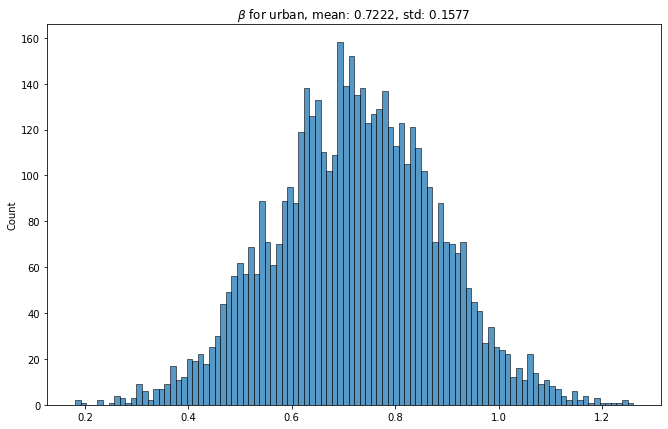

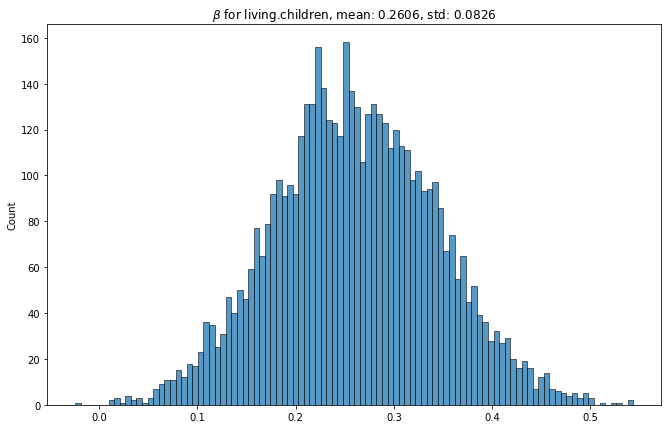

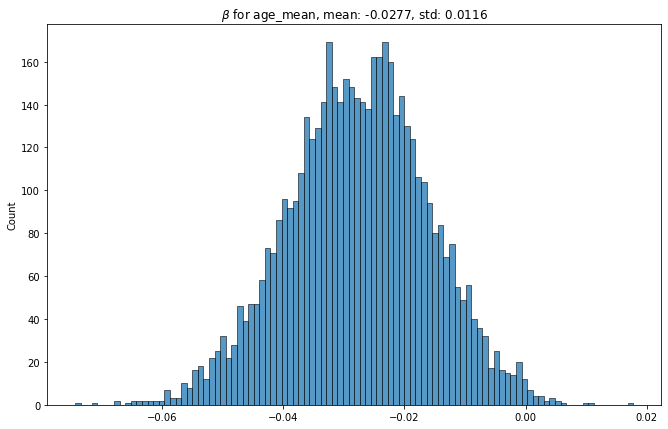

In [12]:
for index, predictor in enumerate(predictor_names):
    beta_samples = np.array(samples["beta"].reshape(-1, X_train.shape[1]))
    beta_j_samples = beta_samples[:,index]

    fig, ax = plt.subplots(figsize=(11, 7))
    # ax.hist(beta_0_samples, bins=100, histtype='step', density=True);
    sns.histplot(beta_j_samples, bins=100, ax=ax);
    
    mean = beta_j_samples.mean()
    std = beta_j_samples.std()
    
    ax.set_title(f"$\\beta$ for {predictor}, mean: {mean:.4f}, std: {std:.4f}")

In [13]:
alpha_samples = samples["alpha"]
beta_samples = samples["beta"].squeeze()

def plot_logistic_curve(predictor_index, x_low, x_high):
    predictor_name = predictor_names[predictor_index]
    fig, ax = plt.subplots(figsize=(12, 7))
    axis_1_points = np.linspace(x_low, x_high, 300)
    for i in range(100):
        axis_2_points = expit(alpha_samples[i] + beta_samples[i][predictor_index] * axis_1_points)

        sns.lineplot(
            x=axis_1_points,
            y=axis_2_points, 
            color='purple', 
            linewidth=0.1,
            ax=ax, 

        )
        ax.set_ylabel("p(y|x)")
        ax.set_xlabel(f"Predictor {predictor_name}")
        ax.set_ylim([0,1])
        ax.set_xlim([x_low, x_high])

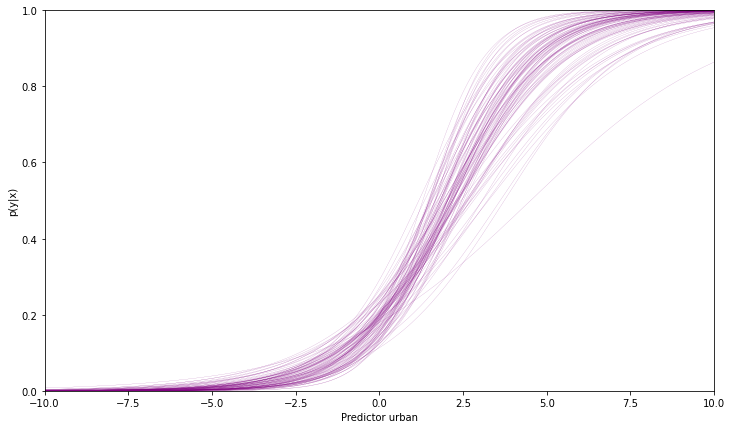

In [14]:
plot_logistic_curve(predictor_index=0, x_low=-10, x_high=10)

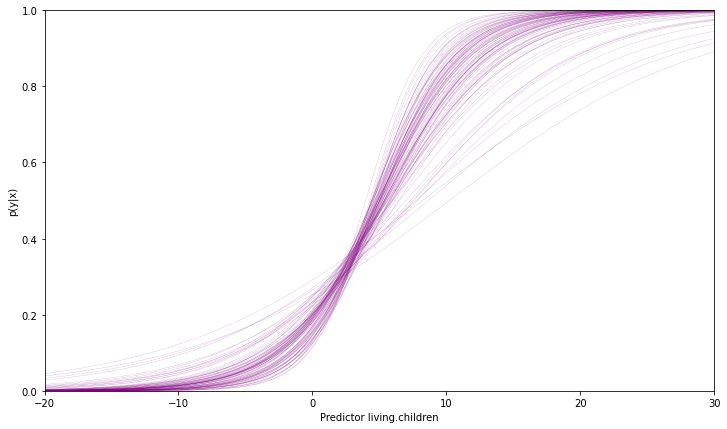

In [15]:
plot_logistic_curve(predictor_index=1, x_low=-20, x_high=30)

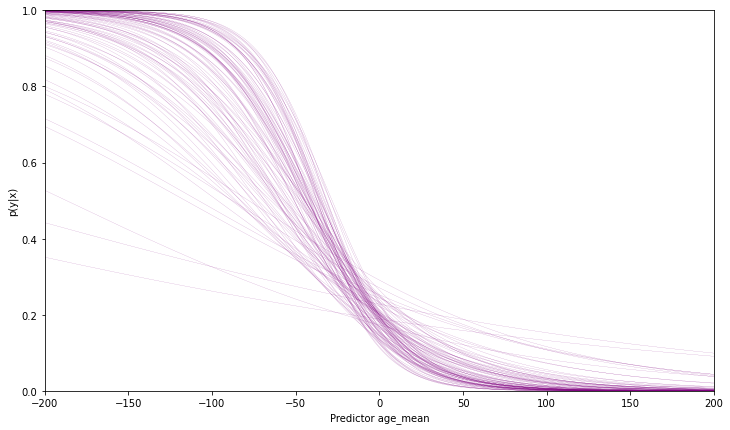

In [16]:
plot_logistic_curve(predictor_index=2, x_low=-200, x_high=200)

In [17]:
beta_samples.shape

(5000, 3)

In [18]:
X_test = jnp.array(df_test[predictor_names])

predictive = Predictive(logistic_regression_model, samples)
predictions = predictive(rng_key_, X=X_test, y=None)

In [19]:
list(predictions.keys())

['delta_proba', 'proba', 'y']

In [20]:
y_pred_test = predictions["proba"].squeeze().T

In [21]:
y_pred_test.shape

(194, 5000)

In [22]:
df_test_aug = df_test.copy()
df_test_aug["y_pred"] = (y_pred_test.mean(axis=1) >= 0.5) * 1

In [23]:
df_test_aug

,district,urban,living.children,age_mean,contraceptive_use,y_pred
432,6,0,3,0.4400,1,0
319,11,0,2,0.4400,0,0
638,40,1,1,0.4400,1,0
787,2,0,4,7.4400,1,0
781,17,0,1,1.4400,0,0
...,...,...,...,...,...,...
309,54,0,2,-0.5599,1,0
442,23,0,3,-4.5599,0,0
683,35,1,1,-6.5599,0,0
206,21,1,4,14.4400,0,0


In [24]:
print(
    classification_report(
        y_true=df_test_aug["contraceptive_use"],
        y_pred=df_test_aug["y_pred"],
    )
)

              precision    recall  f1-score   support

           0       0.58      0.93      0.71       108
           1       0.64      0.16      0.26        86

    accuracy                           0.59       194
   macro avg       0.61      0.54      0.49       194
weighted avg       0.61      0.59      0.51       194

